#**ANALISIS RINCIAN STOCK PADA BEBERAPA PERUSAHAAN**

#Langkah Pertama (Data cleaning, preparation, vizualition)

In [13]:
# Import library yang diperlukan

import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression as SparkLR
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col
from pyspark.sql.functions import when, year, month
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [2]:
# Muat dataset yang digunakan
data = pd.read_csv('stock_details_5_years.csv')
print(data)

# Menampilkan 5 data awal
print("5 Data Awal:")
data.head() #untuk menampilkan beberapa baris pertama dari dataset dengan tabel

                             Date        Open        High         Low  \
0       2018-11-29 00:00:00-05:00   43.829761   43.863354   42.639594   
1       2018-11-29 00:00:00-05:00  104.769074  105.519257  103.534595   
2       2018-11-29 00:00:00-05:00   54.176498   55.007500   54.099998   
3       2018-11-29 00:00:00-05:00   83.749496   84.499496   82.616501   
4       2018-11-29 00:00:00-05:00   39.692784   40.064904   38.735195   
...                           ...         ...         ...         ...   
219518  2020-10-09 00:00:00-04:00   31.858461   32.017836   31.179014   
219519  2020-10-09 00:00:00-04:00   15.170870   15.179252   14.626060   
219520  2020-10-09 00:00:00-04:00   28.177599   28.193435   27.916254   
219521  2020-10-09 00:00:00-04:00  223.832693  226.290043  223.395617   
219522  2020-10-09 00:00:00-04:00  303.438983  305.781154    2.000000   

             Close       Volume  Dividends  Stock Splits Company  
0        43.083508  167080000.0       0.00           0.0

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Company
0,2018-11-29 00:00:00-05:00,43.829761,43.863354,42.639594,43.083508,167080000.0,0.00,0.0,AAPL
1,2018-11-29 00:00:00-05:00,104.769074,105.519257,103.534595,104.636131,28123200.0,0.00,0.0,MSFT
2,2018-11-29 00:00:00-05:00,54.176498,55.007500,54.099998,54.729000,31004000.0,0.00,0.0,GOOGL
3,2018-11-29 00:00:00-05:00,83.749496,84.499496,82.616501,83.678497,132264000.0,0.00,0.0,AMZN
4,2018-11-29 00:00:00-05:00,39.692784,40.064904,38.735195,39.037853,54917200.0,0.04,0.0,NVDA


In [ ]:
# *** Data Cleaning ***
# 1. Menampilkan data dengan nilai kosong
print("Data dengan nilai kosong (missing values):")
print(data[data.isnull().any(axis=1)])

# 2. Menampilkan jumlah missing values per kolom
print("\nJumlah missing values per kolom:")
print(data.isnull().sum())

# Memeriksa apakah ada data duplikat atau tidak
print("\nCek Data Duplikat:")
print(data.duplicated().sum())
data.drop_duplicates(inplace=True)

# Mengisi nilai kosong pada kolom numerik dengan mean
data['Volume'].fillna(data['Volume'].mean(), inplace=True)
data['Dividends'].fillna(data['Dividends'].mean(), inplace=True)

# Mengisi nilai kosong pada kolom 'Stock Splits' dengan nilai tetap (0)
data['Stock Splits'].fillna(0, inplace=True)

# Mengisi nilai kosong pada kolom kategorikal 'Company' dengan modus
data['Company'].fillna(data['Company'].mode()[0], inplace=True)

# Menampilkan dataset setelah proses pembersihan
print("\nDataset setelah pembersihan:")
print(data)

# Mengecek kembali missing values setelah proses pengisian
print("\nJumlah missing values setelah pengisian:")
print(data.isnull().sum())

Data dengan nilai kosong (missing values):
                            Date        Open        High         Low  \
57228  2019-05-31 00:00:00-04:00  152.660004  154.479996  151.259995   

            Close  Volume  Dividends  Stock Splits Company  
57228  151.410003     NaN        NaN           NaN     NaN  

Jumlah missing values per kolom:
Date            0
Open            0
High            0
Low             0
Close           0
Volume          1
Dividends       1
Stock Splits    1
Company         1
dtype: int64

Cek Data Duplikat:
0

Dataset setelah pembersihan:
                            Date        Open        High         Low  \
0      2018-11-29 00:00:00-05:00   43.829761   43.863354   42.639594   
1      2018-11-29 00:00:00-05:00  104.769074  105.519257  103.534595   
2      2018-11-29 00:00:00-05:00   54.176498   55.007500   54.099998   
3      2018-11-29 00:00:00-05:00   83.749496   84.499496   82.616501   
4      2018-11-29 00:00:00-05:00   39.692784   40.064904   38.735195 

<ipython-input-20-6e348f3cc5fd>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Volume'].fillna(data['Volume'].mean(), inplace=True)
<ipython-input-20-6e348f3cc5fd>:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True

In [ ]:
# *** Data Transformation ***

# 1. Melakukan normalisasi pada kolom 'Close'
scaler_minmax = MinMaxScaler()
data['Close'] = scaler_minmax.fit_transform(data[['Close']])

# 2. Melakukan standarisasi pada kolom 'Volume'
scaler_standard = StandardScaler()
data[['Volume']] = scaler_standard.fit_transform(data[['Volume']])

# 3. Menampilkan dataset setelah normalisasi dan standarisasi
print('Setelah normalisasi dan standarisasi:')
print(data.head())

Setelah normalisasi dan standarisasi:
                        Date        Open        High         Low     Close  \
0  2018-11-29 00:00:00-05:00   43.829761   43.863354   42.639594  0.006461   
1  2018-11-29 00:00:00-05:00  104.769074  105.519257  103.534595  0.015918   
2  2018-11-29 00:00:00-05:00   54.176498   55.007500   54.099998  0.008250   
3  2018-11-29 00:00:00-05:00   83.749496   84.499496   82.616501  0.012698   
4  2018-11-29 00:00:00-05:00   39.692784   40.064904   38.735195  0.005839   

      Volume  Dividends  Stock Splits Company  
0  11.666544       0.00           0.0    AAPL  
1   1.608836       0.00           0.0    MSFT  
2   1.817349       0.00           0.0   GOOGL  
3   9.146559       0.00           0.0    AMZN  
4   3.548189       0.04           0.0    NVDA  


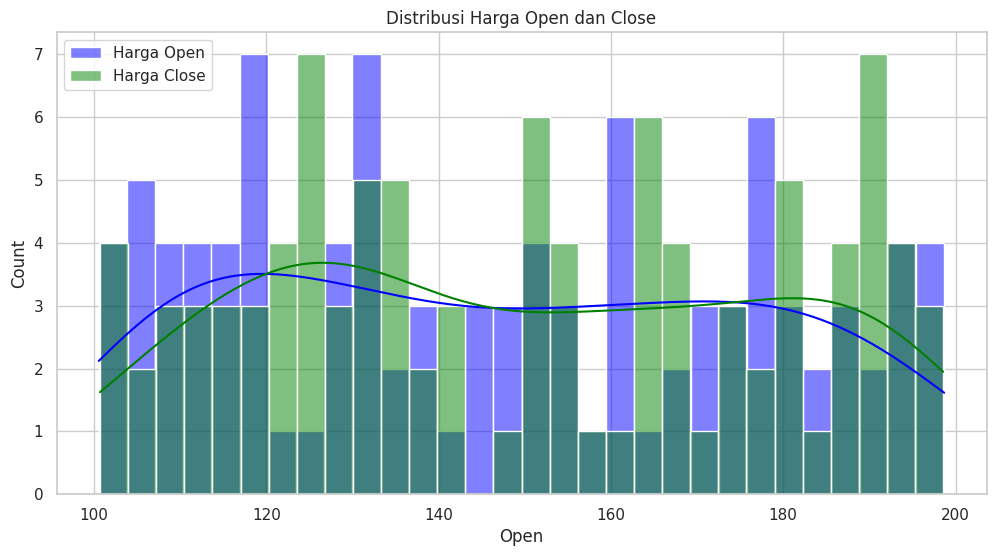

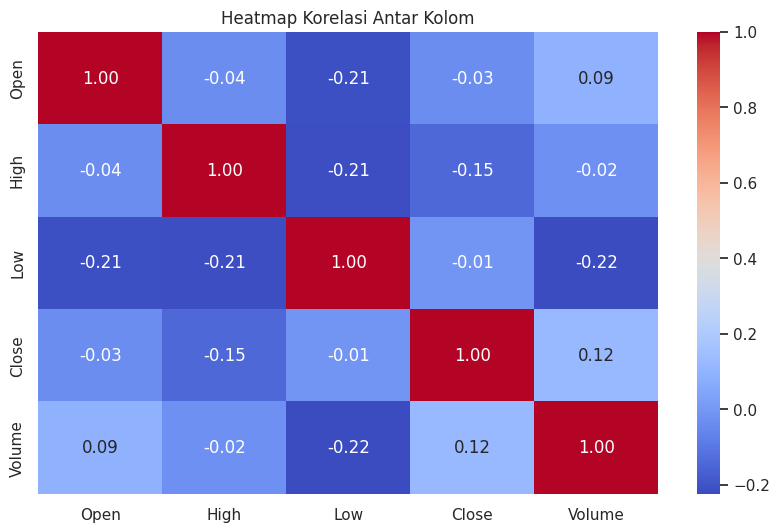

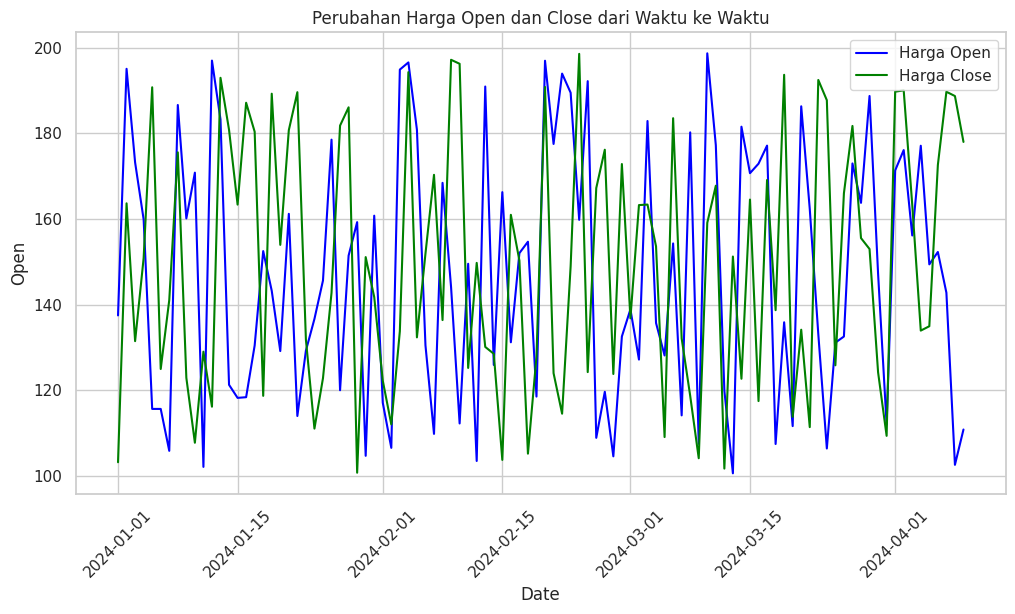

In [ ]:
# *** Data Visualization ***
# Generate data
np.random.seed(42)  # Untuk hasil acak yang sama setiap kali dijalankan
data = {
    "Open": np.random.uniform(100, 200, 100),  # Data harga Open
    "Close": np.random.uniform(100, 200, 100),  # Data harga Close
    "High": np.random.uniform(150, 250, 100),  # Data harga High
    "Low": np.random.uniform(50, 150, 100),  # Data harga Low
    "Volume": np.random.randint(1000, 10000, 100),  # Volume perdagangan
    "Date": pd.date_range(start="2024-01-01", periods=100)  # Tanggal harian
}

df = pd.DataFrame(data)  # Membuat DataFrame

# Set tema untuk seaborn
sns.set(style="whitegrid", palette="muted")

# 1. Histogram dan KDE untuk distribusi data
plt.figure(figsize=(12, 6))
sns.histplot(df['Open'], kde=True, color='blue', label='Harga Open', bins=30)
sns.histplot(df['Close'], kde=True, color='green', label='Harga Close', bins=30)
plt.title('Distribusi Harga Open dan Close')
plt.legend()
plt.show()

# 2. Heatmap untuk melihat korelasi antar kolom
plt.figure(figsize=(10, 6))
correlation = df[['Open', 'High', 'Low', 'Close', 'Volume']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap Korelasi Antar Kolom')
plt.show()

# 3. Time Series Plot untuk perubahan harga dari waktu ke waktu
plt.figure(figsize=(12, 6))
sns.lineplot(x=df['Date'], y=df['Open'], label='Harga Open', color='blue')
sns.lineplot(x=df['Date'], y=df['Close'], label='Harga Close', color='green')
plt.title('Perubahan Harga Open dan Close dari Waktu ke Waktu')
plt.xticks(rotation=45)
plt.legend()
plt.show()

#Langkah Kedua (Pembelajaran Mesin Tingkat Lanjut menggunakan Spark MLlib)

In [14]:
# *** Klasifikasi menggunakan model LogisticRegression ***

# 1. Menentukan label (Target)
data = data.withColumnRenamed("label", "Label")  # Rename 'label' to 'Label'

# 2. Membagi dataset menjadi data latih dan data uji
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# 3. Membangun model klasifikasi
lr = LogisticRegression(featuresCol="features", labelCol="Label")  # Use pyspark LogisticRegression
lr_model = lr.fit(train_data)

# 4. Melakukan prediksi pada data uji
predictions = lr_model.transform(test_data)

# Menampilkan hasil prediksi
print("Hasil Prediksi:")
predictions.select("features", "Label", "prediction").show()

# 5. Menentukan grid parameter untuk tuning
# Make sure to import ParamGridBuilder and CrossValidator again
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# 6. Mengevaluasi performa model
evaluator = MulticlassClassificationEvaluator(labelCol="Label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Akurasi Model sebelum Validasi Silang: {accuracy}")

# *** Hyperparameter Tuning dengan Menerapkan Cross-Validation ***
# 1. Membuat cross-validator
crossval = CrossValidator(
    estimator=lr,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    numFolds=3
)

# 2. Melatih model dengan cross-validation
cv_model = crossval.fit(train_data)

# 3. Mengevaluasi model yang dihasilkan
cv_predictions = cv_model.transform(test_data)
cv_accuracy = evaluator.evaluate(cv_predictions)
print(f"Akurasi Model Setelah Validasi Silang: {cv_accuracy}")

# 2. Menampilkan parameter terbaik
best_model = cv_model.bestModel
print("Parameter Model Terbaik:")
print(f"regParam: {best_model.getRegParam()}")
print(f"elasticNetParam: {best_model.getElasticNetParam()}")

# **Evaluasi dengan AUC (Area Under Curve)**
# Membuat evaluator untuk AUC
binary_evaluator = BinaryClassificationEvaluator(labelCol="Label", rawPredictionCol="prediction", metricName="areaUnderROC")
auc = binary_evaluator.evaluate(predictions)
print(f"AUC: {auc:.4f}")

Hasil Prediksi:
+--------------------+-----+----------+
|            features|Label|prediction|
+--------------------+-----+----------+
|[1.05242472939844...|    1|       1.0|
|[1.13135623931885...|    0|       0.0|
|[1.14012648905228...|    1|       1.0|
|[1.14889666229926...|    0|       1.0|
|[1.1664373570796,...|    0|       0.0|
|[1.17520740795773...|    1|       1.0|
|[1.19274779986697...|    0|       1.0|
|[1.20151799582159...|    0|       0.0|
|[1.21905848672833...|    1|       1.0|
|[1.21905848672833...|    1|       1.0|
|[1.22782855079837...|    0|       0.0|
|[1.2278285904349,...|    0|       0.0|
|[1.22782877121177...|    1|       1.0|
|[1.2365987928551,...|    1|       1.0|
|[1.2453690647296,...|    1|       1.0|
|[1.25413940828772...|    1|       1.0|
|[1.26290957461147...|    0|       1.0|
|[1.2892201206976,...|    0|       0.0|
|[1.30676051851523...|    0|       1.0|
|[1.30676055351658...|    1|       1.0|
+--------------------+-----+----------+
only showing top 20 rows

<ipython-input-15-b913d3fcc1c6>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=label_counts, x="Label", y="count", palette="Blues_d")


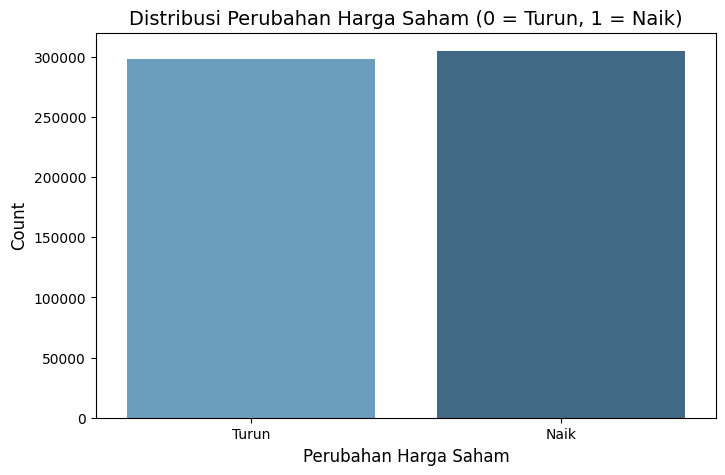

,Label,count
0,1,304943
1,0,298019


In [ ]:
# Cek distribusi kategori label (apakah harga naik atau turun)
label_counts = data.groupBy("Label").count().toPandas()

# Visualisasi distribusi
plt.figure(figsize=(8, 5))
sns.barplot(data=label_counts, x="Label", y="count", palette="Blues_d")
plt.title("Distribusi Perubahan Harga Saham (0 = Turun, 1 = Naik)", fontsize=14)
plt.xlabel("Perubahan Harga Saham", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks([0, 1], ['Turun', 'Naik'])  # Label 0 = Turun, Label 1 = Naik
plt.show()

label_counts

#Referensi:


*   Prananda, Alifia Revan.2024.Hands_On_Pertemuan_14.Universitas Tidar

*   https://dqlab.id/panduan-pemrograman-python-untuk-data-cleansing

*   https://rumahcoding.id/blog normalisasi-dan-standarisasi-data-dengan-scikit-learn/

*   https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8






#Link Dataset:


https://www.kaggle.com/datasets/iveeaten3223times/massive-yahoo-finance-dataset